In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# import EarlyStopping
from pytorchtools import EarlyStopping

import helper
#from network_class import Network

In [44]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [45]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [46]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


In [47]:
def train_net(model, n_epochs, patience, print_every ):

    steps = 0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for e in range(n_epochs):

        model.train()
        running_loss = 0.0

        for images, labels in trainloader:
            steps += 1

            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # images batch to FFNW
            output = model.forward(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, labels)

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())
            #running_loss += loss.item()

            if steps % print_every == 299:
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)

                # print loss statistics
                print("Epoch: {}/{}.. ".format(e+1, n_epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                running_loss = 0

                # Make sure training is back on
                model.train()

        # calculate average loss over an epoch
        train_loss   = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break        
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    print('Finished Training')
    return model, avg_train_losses, avg_valid_losses



In [48]:
# Create the network, define the criterion and optimizer
model = Network(784, 10, [516, 256,128], drop_p=0.2)
print(model)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=516, bias=True)
    (1): Linear(in_features=516, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [49]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams
print_every = 300
patience = 20

model, train_loss, valid_loss = train_net(model, n_epochs, patience, print_every)

Epoch: 1/100..  Training Loss: 0.000..  Test Loss: 0.514..  Test Accuracy: 0.812
Epoch: 1/100..  Training Loss: 0.000..  Test Loss: 0.474..  Test Accuracy: 0.828
Epoch: 1/100..  Training Loss: 0.000..  Test Loss: 0.441..  Test Accuracy: 0.839


C:\Users\Oscar\Anaconda3\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Oscar\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/100..  Training Loss: 0.000..  Test Loss: 0.442..  Test Accuracy: 0.836
Epoch: 2/100..  Training Loss: 0.000..  Test Loss: 0.444..  Test Accuracy: 0.843
Epoch: 2/100..  Training Loss: 0.000..  Test Loss: 0.404..  Test Accuracy: 0.854
Validation loss decreased (inf --> nan).  Saving model ...
Epoch: 3/100..  Training Loss: 0.000..  Test Loss: 0.400..  Test Accuracy: 0.854
Epoch: 3/100..  Training Loss: 0.000..  Test Loss: 0.416..  Test Accuracy: 0.849
Epoch: 3/100..  Training Loss: 0.000..  Test Loss: 0.394..  Test Accuracy: 0.861
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 4/100..  Training Loss: 0.000..  Test Loss: 0.377..  Test Accuracy: 0.858
Epoch: 4/100..  Training Loss: 0.000..  Test Loss: 0.385..  Test Accuracy: 0.863
Epoch: 4/100..  Training Loss: 0.000..  Test Loss: 0.396..  Test Accuracy: 0.860
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 5/100..  Training Loss: 0.000..  Test Loss: 0.376..  Test Accuracy: 0.864
Epoch: 5/100.

Epoch: 28/100..  Training Loss: 0.000..  Test Loss: 0.334..  Test Accuracy: 0.892
Epoch: 28/100..  Training Loss: 0.000..  Test Loss: 0.357..  Test Accuracy: 0.889
Epoch: 28/100..  Training Loss: 0.000..  Test Loss: 0.334..  Test Accuracy: 0.892
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 29/100..  Training Loss: 0.000..  Test Loss: 0.336..  Test Accuracy: 0.884
Epoch: 29/100..  Training Loss: 0.000..  Test Loss: 0.341..  Test Accuracy: 0.893
Epoch: 29/100..  Training Loss: 0.000..  Test Loss: 0.347..  Test Accuracy: 0.890
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 30/100..  Training Loss: 0.000..  Test Loss: 0.341..  Test Accuracy: 0.892
Epoch: 30/100..  Training Loss: 0.000..  Test Loss: 0.330..  Test Accuracy: 0.891
Epoch: 30/100..  Training Loss: 0.000..  Test Loss: 0.344..  Test Accuracy: 0.891
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 31/100..  Training Loss: 0.000..  Test Loss: 0.336..  Test Accuracy: 0.893
Epo

Epoch: 54/100..  Training Loss: 0.000..  Test Loss: 0.375..  Test Accuracy: 0.899
Epoch: 54/100..  Training Loss: 0.000..  Test Loss: 0.364..  Test Accuracy: 0.895
Epoch: 54/100..  Training Loss: 0.000..  Test Loss: 0.375..  Test Accuracy: 0.891
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 55/100..  Training Loss: 0.000..  Test Loss: 0.363..  Test Accuracy: 0.897
Epoch: 55/100..  Training Loss: 0.000..  Test Loss: 0.388..  Test Accuracy: 0.893
Epoch: 55/100..  Training Loss: 0.000..  Test Loss: 0.364..  Test Accuracy: 0.893
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 56/100..  Training Loss: 0.000..  Test Loss: 0.359..  Test Accuracy: 0.894
Epoch: 56/100..  Training Loss: 0.000..  Test Loss: 0.376..  Test Accuracy: 0.894
Epoch: 56/100..  Training Loss: 0.000..  Test Loss: 0.375..  Test Accuracy: 0.896
Epoch: 56/100..  Training Loss: 0.000..  Test Loss: 0.360..  Test Accuracy: 0.895
Validation loss decreased (nan --> nan).  Saving model ...
Epo

Epoch: 79/100..  Training Loss: 0.000..  Test Loss: 0.397..  Test Accuracy: 0.894
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 80/100..  Training Loss: 0.000..  Test Loss: 0.395..  Test Accuracy: 0.896
Epoch: 80/100..  Training Loss: 0.000..  Test Loss: 0.409..  Test Accuracy: 0.897
Epoch: 80/100..  Training Loss: 0.000..  Test Loss: 0.399..  Test Accuracy: 0.896
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 81/100..  Training Loss: 0.000..  Test Loss: 0.411..  Test Accuracy: 0.896
Epoch: 81/100..  Training Loss: 0.000..  Test Loss: 0.415..  Test Accuracy: 0.896
Epoch: 81/100..  Training Loss: 0.000..  Test Loss: 0.415..  Test Accuracy: 0.895
Validation loss decreased (nan --> nan).  Saving model ...
Epoch: 82/100..  Training Loss: 0.000..  Test Loss: 0.412..  Test Accuracy: 0.894
Epoch: 82/100..  Training Loss: 0.000..  Test Loss: 0.431..  Test Accuracy: 0.893
Epoch: 82/100..  Training Loss: 0.000..  Test Loss: 0.408..  Test Accuracy: 0.898
Val

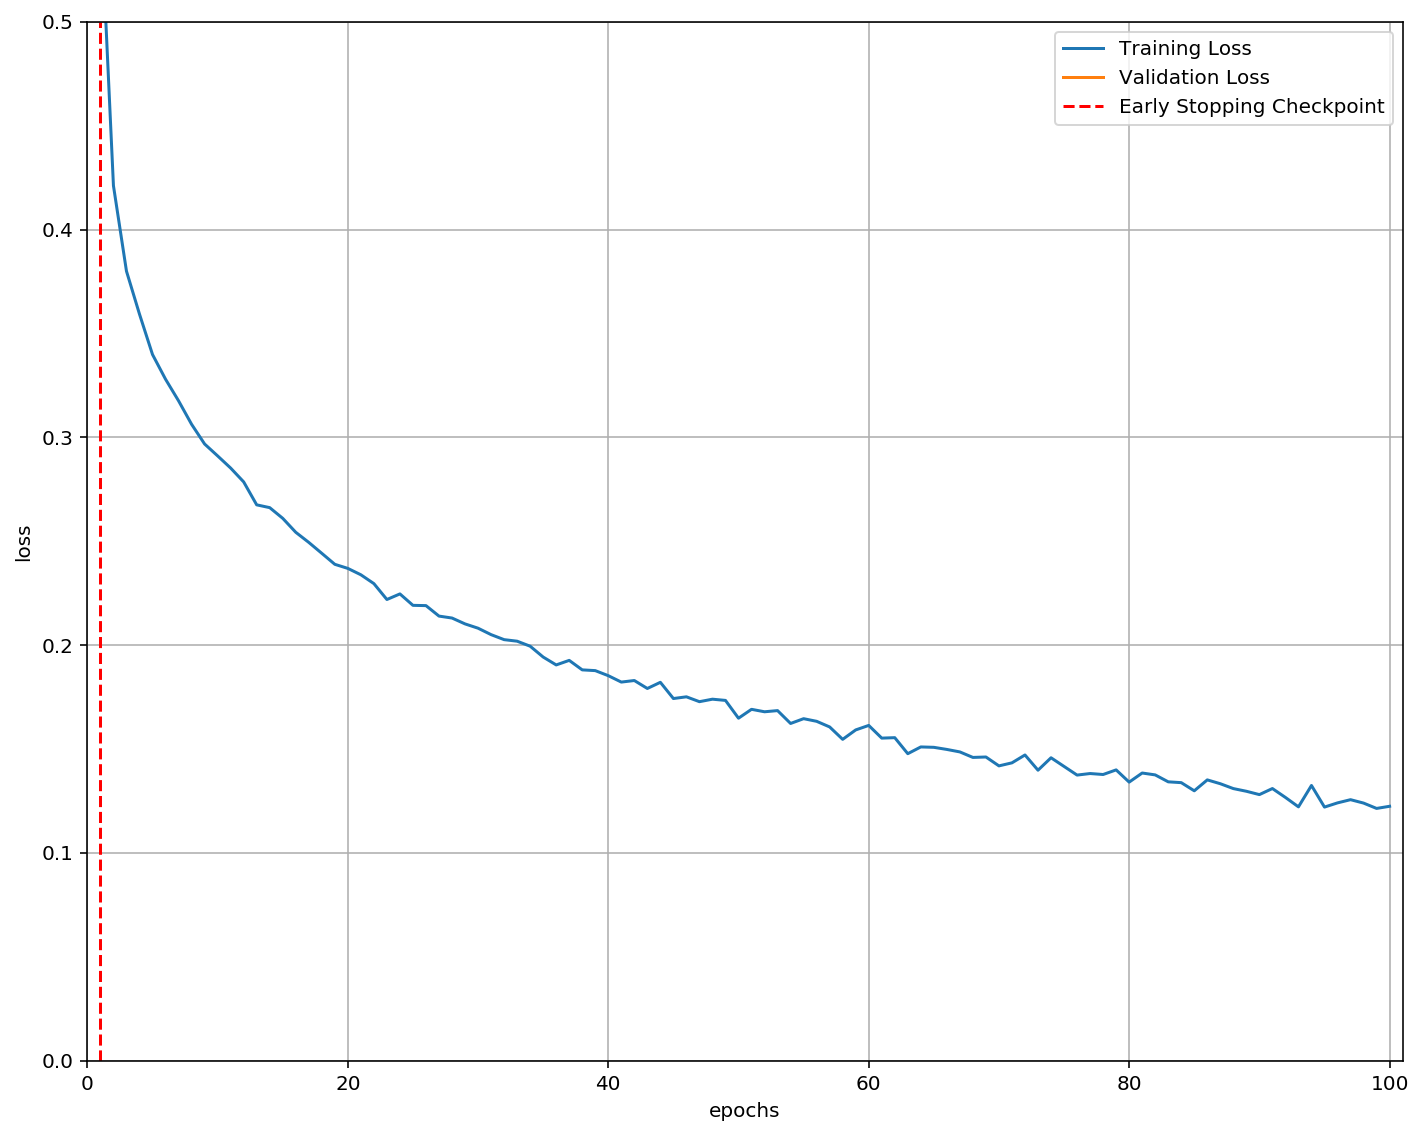

In [51]:

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [52]:
#now we have the model trained we Inference

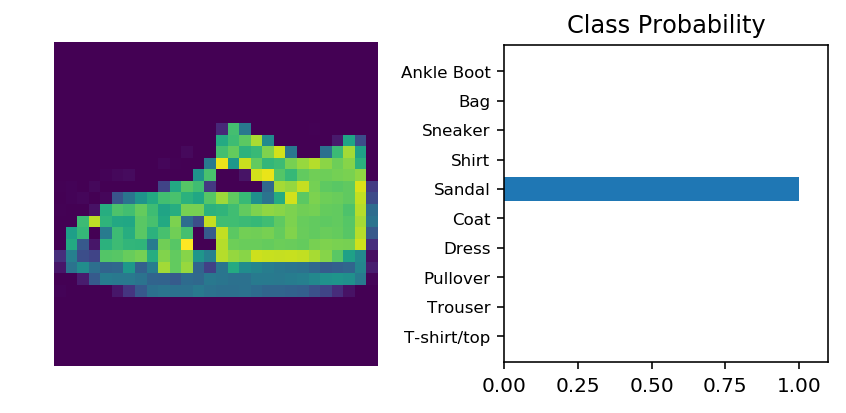

In [58]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')